In [ ]:
"""
import necessary modules
"""
import numpy as np
from dorna2 import Dorna
from camera import Camera
from dorna_vision import Detection
import time
import tube.util as util

"""
parameters
"""
robot_ip_address = "192.168.254.87" # robot ip address
output_config = {
    "pick_init":[0, 0, 0],
    "decap_init": [1, 0, 0],
    "gripper": [0, 1, 0],
    "decap": [1, 1, 0],
    "pick": [0, 1, 1],
    "barcode": [0, 1, 1],
    "decap_place": [0, 1, 0],
}
tcp = {
    "5ml_cap": [0, 0, 50, 0, 0, 90], #3
    "15ml_cap":[0, 0, 40, 0, 0, 90],
    "50ml_cap": [0, 0, 50, 0, 0, 90],
}

decap_round = {
    "5ml_cap": 6,
    "15ml_cap": 7,
    "50ml_cap": 4,
}

imaging_joint = [90.175781, 79.958496, -108.325195, 0.219727, -67.456055, 0]
middle_joint = imaging_joint

# decap
decap_position = {
    "5ml_cap": [167.466961, 275.304174+0.5, 140, 127, -127, 0],
    "15ml_cap": [141.401519, 275.304174+0.5, 140, 127, -127, 0],
    "50ml_cap": [167.466961, 275.304174+0.5, 140, 127, -127, 0],
}

decap_position_down = {
    "5ml_cap": [0, 0, -25+6, 0, 0, 0],
    "15ml_cap": [0, 0, -25+6, 0, 0, 0],
    "50ml_cap": [0, 0, -25+6, 0, 0, 0],
}

tube_position_down = {
    "5ml_cap": [0, 0, -23+4, 0, 0, 0],
    "15ml_cap": [0, 0, -23+4, 0, 0, 0],
    "50ml_cap": [0, 0, -25+2, 0, 0, 0],
}

cap_drop_pose = [258, 57, 140, 180, 0, 0]

#barcode_pose = [323.088207, 293.246132, 140, 127, -127, 0]
barcode_pose = [353.225201+5, 274.642718-25, 140-5, 127, -127, 0]

speed_pick = 0.7 # here set the speed of the robot
above = [40, 140, 140, 140]
motion = "lmove"
sim=0
freedom = {"num" : 10, "range" : [0.5,0.5,0.5], "early_exit": False }

# detection parameters
detection_parameters = {
    "camera_mount":{
        "type": "dorna_ta_j4",
        "ej": [0 ,0,0, 0, 0, 0, 0, 0],
        "T": [46.5174596+1+1, 32.0776662-3+1-0, -4.24772615, -0.27547989, 0.27691881, 89.6939516],
        #"T": [46.5174596, 32.0776662, -4.24772615, -0.27547989, 0.27691881, 89.6939516]
    },
    'detection': {'cmd': 'od', 'path': 'tube.pkl', 'conf': 0.5, 'cls': []}, 
    'limit': {'area': [0, 100000], 'aspect_ratio': [0.1, 1.0], 'xyz': [[-140, 110], [200, 420], [0, 140]], 'inv': 0}, 
    'output': {'max_det': 100, 'shuffle': True, 'save_img': True, 'save_img_roi': True}
    }

# grasp
rvec_base = [180, 0, 0]
padding = 10 # pixel 10
gripper_opening = 55 #mm 50

In [3]:
"""
initialize the robot, camera, and object detection
"""
robot = Dorna() # initialize robot
robot.connect(robot_ip_address) # connect to robot

camera = Camera() # initialize camera
camera.connect() # connect to camera

detection = Detection(camera=camera, robot=robot, **detection_parameters) # initialize the object detection

"""
init robot
"""
robot.set_output(output_config["pick_init"][0], output_config["pick_init"][1]) # set output
robot.set_output(output_config["decap_init"][0], output_config["decap_init"][1]) # set output
robot.set_motor(1) # turn on the robot motors
robot.sleep(1) # sleep to allow the robot to settle before moving

#set safe initial position
robot.go(joint=imaging_joint, speed=speed_pick, sim=sim)

"""
run the object detection and pick and place
"""
for i in range(1):  # range is set to 5 because we have 5 chips
    # always run this to make sure that the rbot is stationary before running the object detection
    time.sleep(0.1)

    s = time.time()
    # run the object detection
    result = detection.run()
    img_1 = detection.img.copy()
    
    # assign tcp to each pose
    for r in result:
        if r["cls"] in tcp:
            r["tcp"] = tcp[r["cls"]]
    
    # best pick
    best_pick_result = util.best_pick(result, rvec_base, detection.camera_data["joint"], robot, detection.frame_mat_inv, camera.camera_matrix(detection.camera_data["depth_int"]), camera.dist_coeffs(detection.camera_data["depth_int"]), padding, gripper_opening, freedom)
    
    if best_pick_result is None:
        break
    else:
        # assign
        pick_pose, label, start, end, pose_valid_list, pose_not_valid_list = best_pick_result
        
        # go second detection
        robot.kinematic.set_tcp_xyzabc(tcp[label])
        second_img_pose = list(pick_pose)
        second_img_pose[2] += above[1]/3
        second_img_pose[1] += -20
        second_img_joint = robot.kinematic.inv(second_img_pose, detection.camera_data["joint"], False,freedom=freedom)[0]
        second_img_joint[5] = 0
        robot.go(joint=second_img_joint, tcp=tcp[label], speed=speed_pick, sim=sim, motion=motion)
        
        # run the object detection
        time.sleep(0.1)
        result = detection.run()
        
        for r in result:
            if np.linalg.norm(np.array(r["xyz"]) - np.array(pick_pose[0:3])) < 10:
                pick_pose[0:3] = r["xyz"]
                # this executes the pick-and-place operation
                retval = robot.pick_n_place(
                    pick_pose=pick_pose, # pick position we got from detection
                    place_pose=barcode_pose, # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["pick"], # output in order (pin, off state, on state)
                    above=above,
                    motion=motion,
                    sim=sim,
                    )

                # barcode
                barcode_result = util.barcode_read(robot)
                
                # go to decap
                retval = robot.pick_n_place(
                    place_pose=decap_position[label], # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["decap_init"], # output in order (pin, off state, on state)
                    above=above[1],
                    motion=motion,
                    sim=sim,
                    )
                
                # decap
                util.decap(robot, label, output_config["gripper"], output_config["decap"], decap_position, decap_position_down, tcp, decap_round[label])

                # drop_cap
                retval = robot.pick_n_place(
                    place_pose=cap_drop_pose, # place poistion which we got from the class
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["gripper"], # output in order (pin, off state, on state)
                    above=above[1]/2,
                    motion=motion,
                    sim=sim,
                    )

                # pick_vial and drop
                retval = robot.pick_n_place(
                    pick_pose = np.array(decap_position[label])+np.array(tube_position_down[label]),
                    place_pose=pick_pose, # place poistion which we got from the class
                    end_joint=imaging_joint,
                    tcp=tcp[label], # tcp is the tool length and postion which we deffined in the cfg cell
                    speed=speed_pick, # speed which we also defined in the cfg cell
                    output_config = output_config["gripper"], # output in order (pin, off state, on state)
                    above=above[1],
                    motion=motion,
                    pick_cmd_list=[{"cmd":"output", "out"+str(output_config["decap"][0]): output_config["decap"][2], "queue":0},
                                   {"cmd": "sleep", "time": 0.5}],
                    sim=sim,
                    freedom = freedom
                )


robot.close() # close robot
camera.close() # close camera
detection.close() # close object detection

start =  (552, 395)
end=  (444, 287)
bb_list= [[[367, 192], [438, 192], [438, 271], [367, 271]], [[871, 486], [951, 486], [951, 559], [871, 559]], [[681, 432], [725, 432], [725, 475], [681, 475]], [[423, 556], [466, 556], [466, 594], [423, 594]], [[882, 394], [958, 394], [958, 470], [882, 470]], [[798, 25], [844, 25], [844, 69], [798, 69]], [[787, 327], [831, 327], [831, 371], [787, 371]], [[796, 131], [839, 131], [839, 175], [796, 175]], [[771, 519], [816, 519], [816, 564], [771, 564]], [[461, 95], [539, 95], [539, 174], [461, 174]], [[428, 466], [470, 466], [470, 509], [428, 509]], [[887, 274], [963, 274], [963, 351], [887, 351]], [[693, 16], [742, 16], [742, 65], [693, 65]], [[362, 297], [439, 297], [439, 373], [362, 373]], [[515, 561], [558, 561], [558, 598], [515, 598]], [[598, 16], [646, 16], [646, 63], [598, 63]], [[888, 172], [962, 172], [962, 246], [888, 246]], [[329, 558], [371, 558], [371, 599], [329, 599]], [[591, 319], [634, 319], [634, 365], [591, 365]], [[589, 125], [637

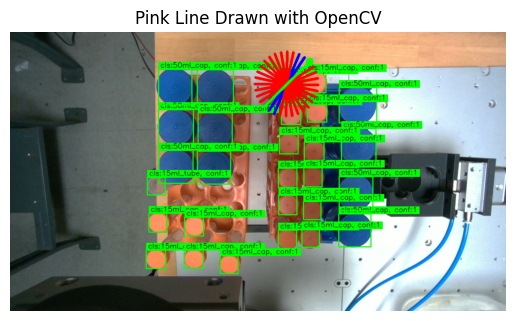

In [14]:
# try_1:  [343.5424054361505, -208.54841173866896, 120.96906205162398]

# "x":345.550535,"y":-208.05732,"z":164.920105
import matplotlib.pyplot as plt
import cv2 as cv

# draw start end
img = img_1.copy()

color = (255, 105, 180)  # Pink line

# Define thickness of the line
thickness = 5

# good
for p in pose_valid_list:
    cv.line(img, p[1], p[2], (255, 0, 0), thickness)

# bad
for p in pose_not_valid_list:
    cv.line(img, p[1], p[2], (0, 0, 255), thickness)

# best
cv.line(img, start, end, (0, 255, 0), thickness)
cv.circle(img, start, 10, (0, 255, 0), -1)


# Convert BGR to RGB for Matplotlib
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)


plt.imshow(img_rgb)
plt.title("Pink Line Drawn with OpenCV")
plt.axis("off")  # Turn off axis
plt.show()

Is the line free? True


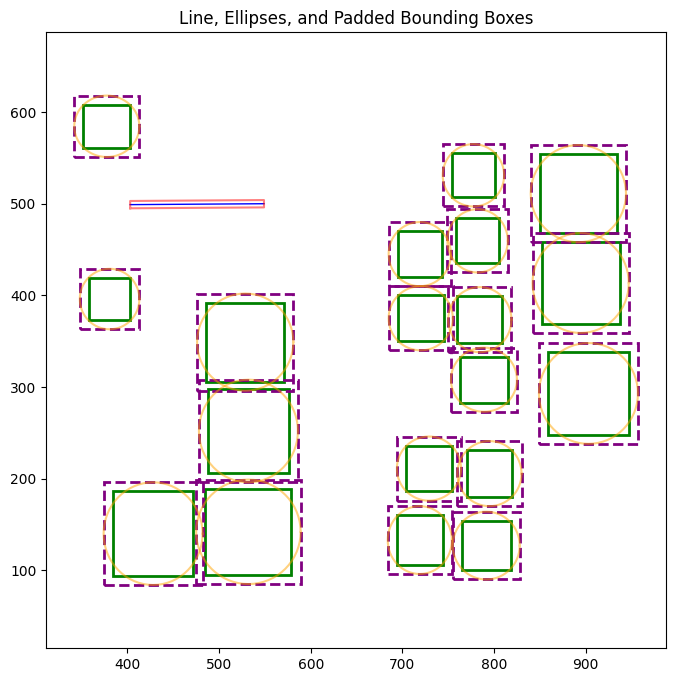

In [5]:
start =  (549, 500)
end=  (403, 499)
bb_list= [[[760, 348], [809, 348], [809, 399], [760, 399]], [[763, 283], [815, 283], [815, 333], [763, 333]], [[384, 94], [472, 94], [472, 186], [384, 186]], [[859, 248], [947, 248], [947, 338], [859, 338]], [[765, 100], [818, 100], [818, 154], [765, 154]], [[694, 106], [744, 106], [744, 160], [694, 160]], [[488, 206], [576, 206], [576, 298], [488, 298]], [[770, 180], [820, 180], [820, 231], [770, 231]], [[352, 561], [403, 561], [403, 608], [352, 608]], [[850, 468], [934, 468], [934, 554], [850, 554]], [[358, 373], [403, 373], [403, 419], [358, 419]], [[486, 306], [571, 306], [571, 392], [486, 392]], [[852, 369], [937, 369], [937, 458], [852, 458]], [[485, 95], [579, 95], [579, 189], [485, 189]], [[704, 186], [754, 186], [754, 236], [704, 236]], [[759, 435], [805, 435], [805, 484], [759, 484]], [[695, 420], [743, 420], [743, 470], [695, 470]], [[695, 350], [745, 350], [745, 400], [695, 400]], [[754, 507], [801, 507], [801, 555], [754, 555]]]


from shapely.geometry import LineString, Point, Polygon
from shapely.affinity import scale
import matplotlib.pyplot as plt
import numpy as np


def free_line_with_ellipses(start, end, bb_list, padding, thickness=8):
    """
    Check if a thickened line between 'start' and 'end' intersects any ellipse 
    inscribed within the bounding boxes (adjusted for padding).
    """
    # Define the line segment and thicken it
    line = LineString([start, end])
    thick_line = line.buffer(thickness / 2, cap_style=2)  # Thickness as radius

    # List to store ellipses and padded bounding boxes for optional plotting
    ellipses = []
    padded_bbs = []

    # Check intersection with all ellipses
    for bb in bb_list:
        # Calculate the coordinates of the expanded bounding box
        bb_array = np.array(bb)
        # Create new expanded bounding box with padding
        padded_bb = np.array([
            [bb_array[0][0] - padding, bb_array[0][1] - padding],
            [bb_array[1][0] + padding, bb_array[1][1] - padding],
            [bb_array[2][0] + padding, bb_array[2][1] + padding],
            [bb_array[3][0] - padding, bb_array[3][1] + padding]
        ])
        
        # Calculate the center and width/height of the padded bounding box
        center = padded_bb.mean(axis=0)
        width = np.abs(padded_bb[1][0] - padded_bb[0][0])
        height = np.abs(padded_bb[2][1] - padded_bb[1][1])

        # Define the inscribed ellipse using scaling
        unit_circle = Point(center).buffer(1)  # Create a unit circle
        ellipse = scale(unit_circle, xfact=width / 2, yfact=height / 2, origin=(center[0], center[1]))
        ellipses.append(ellipse)
        padded_bbs.append(padded_bb)

        # Check if thickened line intersects the ellipse
        if thick_line.intersects(ellipse):
            return False, line, thick_line, bb_list, ellipses, padded_bbs  # Invalid if it intersects

    return True, line, thick_line, bb_list, ellipses, padded_bbs


def plot_line_and_ellipses(line, thick_line, bb_list, ellipses, padded_bbs):
    """
    Plot the line, thickened line, bounding boxes, padded bounding boxes, and ellipses.
    """
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot original line
    ax.plot(*line.xy, label="Original Line", color="blue", linewidth=1)

    # Plot thickened line
    ax.plot(*thick_line.exterior.xy, label="Thickened Line", color="red", alpha=0.5)

    # Plot original bounding boxes and ellipses
    for bb, ellipse in zip(bb_list, ellipses):
        # Plot original bounding box
        ax.add_patch(plt.Polygon(bb, fill=None, edgecolor="green", linewidth=2, label="Bounding Box"))
        
        # Plot ellipse
        ax.plot(*ellipse.exterior.xy, label="Ellipse", color="orange", alpha=0.5)

    # Plot padded bounding boxes
    for padded_bb in padded_bbs:
        ax.add_patch(plt.Polygon(padded_bb, fill=None, edgecolor="purple", linestyle='--', linewidth=2, label="Padded Bounding Box"))

    #ax.legend()
    ax.set_aspect("equal", adjustable="datalim")
    plt.title("Line, Ellipses, and Padded Bounding Boxes")
    plt.show()


padding = 10
thickness = 8

# Check and plot
result, line, thick_line, bb_list, ellipses, padded_bbs = free_line_with_ellipses(start, end, bb_list, padding, thickness)
print("Is the line free?", result)

# Plot the result
plot_line_and_ellipses(line, thick_line, bb_list, ellipses, padded_bbs)


In [11]:
# Tencent is pleased to support the open source community by making ncnn available.
#
# Copyright (C) 2020 THL A29 Limited, a Tencent company. All rights reserved.
#
# Licensed under the BSD 3-Clause License (the "License"); you may not use this file except
# in compliance with the License. You may obtain a copy of the License at
#
# https://opensource.org/licenses/BSD-3-Clause
#
# Unless required by applicable law or agreed to in writing, software distributed
# under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR
# CONDITIONS OF ANY KIND, either express or implied. See the License for the
# specific language governing permissions and limitations under the License.

import sys
import cv2
from ncnn.model_zoo import get_model
from ncnn.utils import draw_pose
import time


if __name__ == "__main__":
    imagepath = "human.jpg"

    m = cv2.imread(imagepath)
    if m is None:
        print("cv2.imread %s failed\n" % (imagepath))
        sys.exit(0)

    net = get_model("simplepose", num_threads=4, use_gpu=False)
    s = time.time()
    keypoints = net(m)
    print(time.time()-s)
    draw_pose(m, keypoints)

0.05954456329345703
202.50 50.62 = 0.92418
213.75 45.00 = 0.96757
191.25 45.00 = 0.94567
225.00 45.00 = 0.83335
180.00 50.62 = 0.93330
202.50 78.75 = 0.85018
168.75 84.38 = 0.85226
213.75 123.75 = 0.77542
146.25 135.00 = 0.87581
247.50 140.62 = 0.88747
135.00 185.62 = 0.90453
191.25 174.38 = 0.73215
180.00 174.38 = 0.79994
180.00 247.50 = 0.83006
213.75 247.50 = 0.87428
146.25 309.38 = 0.84402
225.00 320.62 = 0.88877
